## Project setup

In [1]:
# import required libraries
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import warnings
from sklearn import mixture
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.linear_model import LinearRegression
import itertools
import seaborn as sns

# 
# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(20,5)  
matplotlib.rcParams['font.size']=16    
matplotlib.rcParams['savefig.dpi']= 300   
warnings.filterwarnings('ignore')

# functions
def in_hull(p, hull):
    # """
    # code from https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl, by user Juh_
    # Test if points in `p` are in `hull`

    # `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    # `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    # coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    # will be computed
    # """
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

Populating the interactive namespace from numpy and matplotlib


## Initial data entry

In [2]:
# import data from Data directory
allPointsFiles = glob.glob('../Data/*/*/points.txt')
allFuzzyFiles = glob.glob('../Data/*/*/fuzzy.txt')
allVaryingPointFiles = glob.glob('../Data/*/*/P*.csv')
allXrayFiles = glob.glob('../Data/XrayFlash.txt')

# initiate initial variables
farPoints = []
farPointsSph = []
midPoints = []
midPointsSph = []
closePoints = []
closePointsSph = []
allPoints = []
allPointsSph = []
variablePoints = []
xRayPoints = []
xRayPointsSph = []
fuzzies = []
fuzziesSph = []
name2ID = []
# initial loading and sorting
# points (row = [name, x, y, distance, HRx, HRy, RV])

# initiate parameters
upperParallaxLimit = 0.006
lowerParallaxLimit = 0.005
ID=100000
# sort the points
for j, pointsFile in enumerate(allPointsFiles):
    try:
        this = Table.read(pointsFile,format='ascii')
        thispar = this['par']
        thism0, thism1, thism2 = (np.log10(this['flux1']), 
                                  np.log10(this['flux2']), 
                                  np.log10(this['flux3']))
        thiscolour = thism2-thism0
        # transform coords onto "sky net" based on file path and store in numpy array          
        if pointsFile.rfind('Up')!=-1:
            pointsSph = np.array([this['name'], (180/np.pi)*(np.arctan2(this['y'],this['x']))+90, (180/np.pi)*(np.arctan2(np.sqrt(np.square(this['x'])+np.square(this['y'])),45)), thispar, thiscolour, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Front')!=-1:
            pointsSph = np.array([this['name'], this['x'],  this['y']+90, thispar, thiscolour, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Right')!=-1:
            pointsSph = np.array([this['name'], this['x']+90, this['y']+90, thispar, thiscolour, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Back')!=-1:
            pointsSph = np.array([this['name'], this['x']+180, this['y']+90, thispar, thiscolour, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Left')!=-1:
            pointsSph = np.array([this['name'], this['x']-90, this['y']+90, thispar, thiscolour, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Down')!=-1:
            pointsSph = np.array([this['name'],  (180/np.pi)*(np.arctan2(this['y'],this['x']))-90, 180 -(180/np.pi)*(np.arctan2(np.sqrt(np.square(this['x'])+np.square(this['y'])),45)), thispar, thiscolour, thism1, this['rv']]).T.tolist()
            
        # sort into close and far
        for point in points:
            ID=ID+1
            name2ID.append([point[0],ID])
            point[0]=str(ID)
            if float(point[3]) > upperParallaxLimit:
                closePoints.append(point)
            elif float(point[3]) <= lowerParallaxLimit:# value chosen to minimize clusters being assigned to mid distance
                farPoints.append(point)   
            else:
                midPoints.append(point)  
        for point in pointsSph:
            ID=ID+1
            name2ID.append([point[0],ID])
            point[0]=str(ID)
            if float(point[3]) > upperParallaxLimit:
                closePointsSph.append(point)
            elif float(point[3]) <= lowerParallaxLimit:# value chosen to minimize clusters being assigned to mid distance
                farPointsSph.append(point)   
            else:
                midPointsSph.append(point)  
    except Exception as e:
        print('Failed point sorting: '+ str(e))
        pass
closePointsSph=np.array(closePointsSph).astype(np.float)
midPointsSph=np.array(midPointsSph).astype(np.float).astype(np.float)
farPointsSph=np.array(farPointsSph).astype(np.float)
closePoints=np.array(closePoints).astype(np.float)
midPoints=np.array(midPoints).astype(np.float).astype(np.float)
farPoints=np.array(farPoints).astype(np.float)
allPoints=np.concatenate((closePoints, midPoints, farPoints),axis=0).astype(np.float)
# fuzzies (row = [name, x, y, flux1, flux2, flux3, width, RV])
FuzzyID=200000
for j, fuzzyFile in enumerate(allFuzzyFiles):
    try:
        this = Table.read(fuzzyFile,format='ascii')
        # transform coords onto "sky net" based on file path and store in numpy array          
        if fuzzyFile.rfind('Up')!=-1:
            fuzzySph = np.array([this['name'], (180/np.pi)*(np.arctan2(this['y'],this['x']))+90, (180/np.pi)*(np.arctan2(np.sqrt(np.square(this['x'])+np.square(this['y'])),45)), this['flux0'], this['flux1'],this['flux2'], this['width'], this['rv']]).T.tolist()
            
        elif fuzzyFile.rfind('Front')!=-1:
            fuzzySph = np.array([this['name'], this['x'],  this['y']+90, this['flux0'], this['flux1'],this['flux2'], this['width'], this['rv']]).T.tolist()
            
        elif fuzzyFile.rfind('Right')!=-1:
            fuzzySph = np.array([this['name'],  this['x']+90, this['y']+90, this['flux0'], this['flux1'],this['flux2'], this['width'], this['rv']]).T.tolist()
            
        elif fuzzyFile.rfind('Back')!=-1:
            fuzzySph = np.array([this['name'],  this['x']+180, this['y']+90,  this['flux0'], this['flux1'],this['flux2'], this['width'], this['rv']]).T.tolist()
            
        elif fuzzyFile.rfind('Left')!=-1:
            fuzzySph = np.array([this['name'],  this['x']-90, this['y']+90, this['flux0'], this['flux1'],this['flux2'], this['width'], this['rv']]).T.tolist()
            
        elif fuzzyFile.rfind('Down')!=-1:
            fuzzySph = np.array([this['name'],    (180/np.pi)*(np.arctan2(this['y'],this['x']))-90,      180 - (180/np.pi)*(np.arctan2(np.sqrt(np.square(this['x']) + np.square(this['y'])),45)),      this['flux0'], this['flux1'],this['flux2'], this['width'], this['rv']]).T.tolist()
        for fuzzy in fuzzy:
            FuzzyID=FuzzyID+1
            name2ID.append([fuzzySph[0],FuzzyID])
            fuzzy[0]=str(ID)
            fuzziesSph.append(fuzzySph)
        for fuzzy in fuzzySph:
            FuzzyID=FuzzyID+1
            name2ID.append([fuzzy[0],FuzzyID])
            fuzzy[0]=str(ID)
            fuzzies.append(fuzzy)
            
    except Exception as e:
        print('fuzzy Failed: '+ str(e))
        
        pass
fuzzies = np.array(fuzzies).astype(np.float)
fuzziesSph = np.array(fuzziesSph).astype(np.float)

name2ID=np.array(name2ID)
# Xray flashes (row = [x, y, luminosity])
for j, XrayFiles in enumerate(allXrayFiles):
    Xrays = []
    try:
        this = Table.read(XrayFiles,format='ascii')
        for line in this:
            # transform coords onto "sky net" based on file path and store in numpy array          
            if line['Camera']==('Up'):
                Xrays = np.array([line['y'], -line['x']+90, line['mag']]).T.tolist()
                XraysSph = np.array([ 180/np.pi*(np.arctan2(line['y'],line['x']))+90, 180/np.pi*(np.arctan2(np.sqrt(np.square(line['x'])+np.square(line['y'])),45)) , line['mag']]).T.tolist()
            elif line['Camera']==('Front'):
                Xrays = np.array([ line['y']-90, -line['x']+90, line['mag']]).T.tolist()
                XraysSph = np.array([ line['x'],  line['y']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Right'):
                Xrays = np.array([ line['x'], line['y'], line['mag']]).T.tolist()
                XraysSph = np.array([  line['x']+90, line['y']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Back'):
                Xrays = np.array([line['x']+90, line['y'], line['mag']]).T.tolist()
                XraysSph = np.array([  line['x']+180, line['y']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Left'):
                Xrays = np.array([ line['y']-90, -line['x']+270, line['mag']]).T.tolist()
                XraysSph = np.array([  line['x']-90, line['y']+90,line['mag']]).T.tolist()
            elif line['Camera']==('Down'):
                Xrays = np.array([ line['y'], -line['x']-90, line['mag']]).T.tolist()
                XraysSph = np.array([ (180/np.pi)*(np.arctan2(line['y'],line['x']))-90, 180 - (180/np.pi)*(np.arctan2(np.sqrt(np.square(line['x'])+np.square(line['y'])),45)), line['mag']]).T.tolist()

            xRayPointsSph.append(XraysSph)
            xRayPoints.append(Xrays)
    except Exception as e:
        print('Failed: '+ str(e))
        pass
xRayflashesSph=np.array(xRayPointsSph).astype(np.float)
xRayflashes=np.array(xRayPoints).astype(np.float)

# Variable points (row = [name, x, y, dist, HRx, HRy, abs mag, RV, variable data])
for j, varsFile in enumerate(allVaryingPointFiles):
    
    try:
        thisVar = np.array(Table.read(varsFile,format='ascii'))
        name = varsFile[-10:-4]
        pointID=name2ID[name2ID[:,0]==name,1][0]
        basicData=allPoints[(closePoints[:,0]==pointID.astype(np.float)),:]
        variablePoint=np.array([basicData[0,0],basicData[0,1],basicData[0,2],basicData[0,3],basicData[0,4],basicData[0,5],basicData[0,6],thisVar])
        variablePoints.append(variablePoint)
    except Exception as e:
        print('Failed: '+ str(e))
        print(varsFile[-10:-4])
        pass
variablePoints=np.array(variablePoints)


# Points analysis

## Calculate Main sequence flattener

In [3]:
# transform HRy
absMag = closePoints[:,5].astype(np.float) + 2*np.log10(1/closePoints[:,3].astype(np.float))
BenchMark = np.array([closePoints[:,4].astype(np.float), absMag]).T
branches=[]
# Identify benchmark main seqence cluster with BGMM
branchCount = 4   # clusterCount
tol=0.0005
countStep = 5
CountTrials = 10
branchesModel = (mixture.BayesianGaussianMixture(
                tol=tol,
                n_components=branchCount,
                covariance_type="full",
                n_init = CountTrials
                )).fit(BenchMark)    
branchShapes = branchesModel.predict(BenchMark)
# Collate branch points
for i, (weights) in enumerate(branchesModel.weights_):
    if not np.any(branchShapes == i) or weights<(0.01/branchCount):
        continue        
    branches.append(BenchMark[branchShapes == i, :])
## get Main sequence to fit polynomial
clusterSize=0
i=0
MSindex=0
for branch in branches:
    if len(branch)>clusterSize:
        clusterSize=len(branch)
        MSindex=i
    i=i+1
mainSequenceBenchmark=branches[MSindex]
MSFit4=np.poly1d(np.polyfit(mainSequenceBenchmark[:,0],mainSequenceBenchmark[:,1],4))
MSFit1=np.poly1d(np.polyfit(mainSequenceBenchmark[:,0],mainSequenceBenchmark[:,1],1))
# Transform all close points HR values
BenchMarktHRx=BenchMark[:,0]
BenchMarktHRy=BenchMark[:,1]-np.power(BenchMark[:,0],4)*MSFit4.c[0]-np.power(BenchMark[:,0],3)*MSFit4.c[1]-np.power(BenchMark[:,0],2)*MSFit4.c[2]-BenchMark[:,0]*MSFit4.c[3]-MSFit4.c[4]
linearBenchMarktHRy=BenchMark[:,1]-BenchMark[:,0]*MSFit1.c[0]-MSFit1.c[1]



## breakdown point clusters

In [4]:
# Initiate output arrays
protoClusters = []
subClusters = []    #row = [ID, x, y, HRx, tHRy, rv]
clusters = []
# initiate input arrays
# X row = [ID, x, y, HRx, HRy, rv]
unassigned = []
# get protoClusters
X=np.concatenate([farPoints[:,[0,1,2,4,5,6]], midPoints[:,[0,1,2,4,5,6]]]).astype(np.float)
numberOfClusters = 1
NOCinc = 1
trials = 10
tol=0.001
WCP = 1
MPR = 1
minClusterSize=4
features=[1,2,5]
ProtoClustersModel = (mixture.BayesianGaussianMixture(
                tol=tol,
                weight_concentration_prior=WCP,
                mean_precision_prior=MPR,
                n_components=numberOfClusters,
                covariance_type="full",
                n_init = trials
                )).fit(X[:,features])
while min(ProtoClustersModel.weights_)>(0.01/numberOfClusters):
    
    numberOfClusters=numberOfClusters+NOCinc
    
    ProtoClustersModel = (mixture.BayesianGaussianMixture(
                    weight_concentration_prior=WCP,
                    mean_precision_prior=MPR,
                    tol=tol,
                    n_components=numberOfClusters,
                    covariance_type="full",
                    n_init = trials
                    )).fit(X[:,features])
ProtoClustersModel = (mixture.BayesianGaussianMixture(
                tol=tol,
                weight_concentration_prior=WCP,
                mean_precision_prior=MPR,
                n_components=numberOfClusters-1,
                covariance_type="full",
                n_init = trials
                )).fit(X[:,features])
protoClusterShapes = ProtoClustersModel.predict(X[:,features])
for i, weights in enumerate(ProtoClustersModel.weights_):
    
    if not np.any(protoClusterShapes == i) or weights<(0.01/numberOfClusters) or len(X[protoClusterShapes == i, :])<minClusterSize:
        print('rejected: ', str(len(X[protoClusterShapes == i, :])))
        try:
            unassigned.append(X[protoClusterShapes == i, :].tolist()[0])
            continue
        except:
            continue
    protoClusters.append(X[protoClusterShapes == i, :])
totalPointsP = 0

# get subClusters
for protoCluster in protoClusters:
    # parameters
    tol=0.001
    numberOfSubClusterCount = 3   #initial clusterCount
    minSubclusterSize = 30
    trials = 10
    features=[1,2,5]
    subClustersModel = (mixture.BayesianGaussianMixture(
                        tol=tol,
                        n_components=numberOfSubClusterCount,
                        covariance_type="full",
                        )).fit(protoCluster[:,features])
    while min(subClustersModel.weights_)>(0.1/numberOfSubClusterCount):
        numberOfSubClusterCount = numberOfSubClusterCount + 1
        subClustersModel = (mixture.BayesianGaussianMixture(
                            n_init = trials,
                            tol=tol,
                            n_components=numberOfSubClusterCount,
                            covariance_type="full",
                            )).fit(protoCluster[:,features])
    subClustersModel = (mixture.BayesianGaussianMixture(
                        n_init = trials,
                        tol=tol,
                        n_components=numberOfSubClusterCount-1,
                        covariance_type="full",
                        )).fit(protoCluster[:,features])
    subClusterShapes = subClustersModel.predict(protoCluster[:,features])
# collate subclusters
    for i, (weights) in enumerate(subClustersModel.weights_):
        if not np.any(subClusterShapes == i) or len(protoCluster[subClusterShapes == i, :])<minSubclusterSize:
            try:
                test = protoCluster[subClusterShapes == i, :].tolist()[:][:]
                unassigned.extend(protoCluster[subClusterShapes == i, :].tolist()[:][:])
                # print('unassigned 1')
            except:
                print('')
            continue
        temp=protoCluster[subClusterShapes == i, :]
        subClusters.append(np.array([temp[:,0],temp[:,1],temp[:,2],temp[:,3],temp[:,4], temp[:,5]]).T)
subClusters=np.array(subClusters)        

## Rebuild points clusters

In [5]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from scipy.interpolate import griddata
# Calculate prereq cluster data (boundary, Main sequence HRy, RV profile)
# 
        # tHRy = temp[:,4]-np.square(temp[:,3])*MSFit.c[0]-temp[:,3]*MSFit.c[1]-MSFit.c[2]

subClusterMS = []
boundaries = []
RVP = []
for subCluster in subClusters:
    Xms = np.array([subCluster[:,3], subCluster[:,4]-np.power(subCluster[:,3],4)*MSFit4.c[0]-np.power(subCluster[:,3],3)*MSFit4.c[1]-np.power(subCluster[:,3],2)*MSFit4.c[2]-subCluster[:,3]*MSFit4.c[3]-MSFit4.c[4]]).T
    ltHRy = np.array([subCluster[:,3],subCluster[:,4]-subCluster[:,3]*MSFit1.c[0]-MSFit1.c[1]]).T

    branches=[]
    # Identify benchmark main seqence cluster with BGMM
    branchCount = 3   # clusterCount
    countStep = 5
    CountTrials = 3
    branchesModel = (mixture.BayesianGaussianMixture(
                    n_components=branchCount,
                    covariance_type="full",
                    n_init = CountTrials
                    )).fit(ltHRy)    
    branchShapes = branchesModel.predict(ltHRy)
    # Collate branch points
    for i, (weights) in enumerate(branchesModel.weights_):
        if not np.any(branchShapes == i) or weights<(0.01/branchCount):
            continue        
        branches.append(Xms[branchShapes == i, :])
    ## get Main sequence to fit polynomial
    clusterSize=0
    i=0
    MSindex=0
    for branch in branches:
        if len(branch)>clusterSize:
            clusterSize=len(branch)
            MSindex=i
        i=i+1
    subClusterMS.append(branches[MSindex][branches[MSindex][:,0]>-0.6,:])
    
    
    boundary=subCluster[:,[1,2]]
    boundaries.append(Delaunay(boundary))   
    # get RVfit
    xi, yi = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
    RVP.append(griddata(subCluster[:,[1,2]], subCluster[:,5], (xi,yi), method='cubic'))
    
boundaries = np.array(boundaries) 
xi, yi = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))   
clusters = subClusters
clusterMS = np.array(subClusterMS)
exists = np.ones(len(clusters)).astype(int)
oldExistSum=np.infty
while np.sum(exists)<oldExistSum:
    oldExistSum=np.sum(exists)
    exists = np.ones(len(clusters)).astype(int)
    for h, hostCluster in enumerate(clusters):
        # get cluster boundary
        if exists[h]==1:
            for i, otherCluster in enumerate(clusters):
                overlap = sum(abs(in_hull(otherCluster[:,[1,2]], boundaries[h])))
                difMeans = np.sqrt((np.mean(otherCluster[:,1])-np.mean(hostCluster[:,1]))**2 + (np.mean(otherCluster[:,2])-np.mean(hostCluster[:,2]))**2)
                maxRH = max(np.sqrt((hostCluster[:,1]-np.mean(hostCluster[:,1]))**2 + (hostCluster[:,2]-np.mean(hostCluster[:,2]))**2))
                maxRO = max(np.sqrt((otherCluster[:,1]-np.mean(otherCluster[:,1]))**2 + (otherCluster[:,2]-np.mean(otherCluster[:,2]))**2))
                maxR =maxRH + maxRO
                if (exists[i]==1):
                    # print("Host: ", h, ', index: ', i, 'overlap: ', overlap)                                         # only use existing clusters
                    if (i != h
                    and (overlap>0                                        # overlap checker
                    or difMeans<maxR)
                       ):
                            tTest=sp.stats.ttest_ind(clusterMS[h][:,1], clusterMS[i][:,1], axis=0, equal_var=False)
                            # print('        ',tTest)
                            if tTest[1]>0.05:
                                # print('        ', h, ' match with ', i)

                                clusters[h] = np.append(clusters[h],clusters[i],axis=0)      # Update host
                                boundaries[h] = Delaunay(clusters[h][:,[1,2]])
                                clusterMS[h] =  np.append(clusterMS[h],clusterMS[i],axis=0) 
                                # RVP[h] = sp.griddata(clusters[:,[1,2]], clusters[:,5], (xi,yi), method='cubic')
                                exists[i] = 0
    clusters=clusters[exists == 1]
    boundaries = boundaries[exists == 1]    
    clusterMS = clusterMS[exists == 1]
clusterStats = []
for i, cluster in enumerate(clusters):
      
    # get RVfit
    # xi, yi = np.meshgrid(
    #     np.concatenate((np.linspace(min(cluster[:,1]),max(cluster[:,1]),20),(boundaries[i].simplices[:,0])),axis=0),
    #     np.concatenate((np.linspace(min(cluster[:,2]),max(cluster[:,2]),20),(boundaries[i].simplices[:,1])),axis=0))
    ax = np.linspace(min(cluster[:,1]),max(cluster[:,1]),100)
    bx = np.linspace(min(cluster[:,2]),max(cluster[:,2]),100)
    xi,yi = np.meshgrid(ax,bx)
    RVP = griddata(cluster[:,[1,2]], cluster[:,5], (xi,yi), method='cubic', fill_value=np.mean(cluster[:,5]))
    RV = np.mean(cluster[:,5])
    anglexa=np.arctan(
        ((np.argmax(RVP,axis=0)[np.argmin(np.max(RVP,axis=0))] - np.argmin(RVP,axis=0)[np.argmin(np.min(RVP,axis=0))])*(ax[1]-ax[0]))/
        ((np.argmax(RVP,axis=1)[np.argmin(np.max(RVP,axis=1))] - np.argmin(RVP,axis=1)[np.argmin(np.min(RVP,axis=1))])*(bx[1]-bx[0]))
    )
    D = 10**(-np.mean(clusterMS[i][:,1])/2)
    x = np.mean(cluster[:,1])
    y = np.mean(cluster[:,2])
    stdD = np.std(10**(-np.mean(clusterMS[i][:,1])/2))
    stdx = np.std(cluster[:,1])
    stdy = np.std(cluster[:,2])
    # stda = np.std(cluster[:,1])*np.cos(anglexa) + np.std(cluster[:,2])*np.sin(anglexa)  #standard deviation in long axis
    # stdb = np.std(cluster[:,2])*np.cos(anglexa) + np.std(cluster[:,1])*np.sin(anglexa)  #standard deviation in short axis
    
    clusterStats.append([(x,y,D),(stdx,stdy,stdD),anglexa,RVP,RV])
clusterStats = np.array(clusterStats)    
    

## Plots

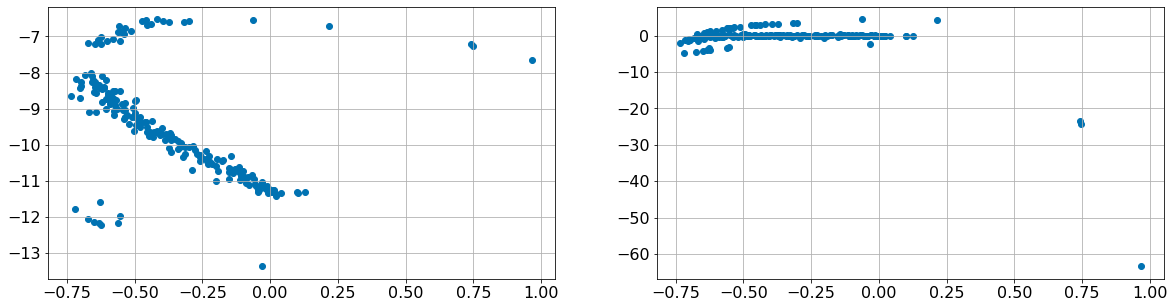

In [6]:
# Plot benchmark
BMplot = mpl.pyplot.figure()
### Sky map cluster plot
ax1 = BMplot.add_subplot(1, 2, 1)
plt.grid()
mpl.pyplot.scatter(BenchMarktHRx, BenchMark[:,1])
ax1 = BMplot.add_subplot(1, 2, 2)
plt.grid()
mpl.pyplot.scatter(BenchMarktHRx, BenchMarktHRy)

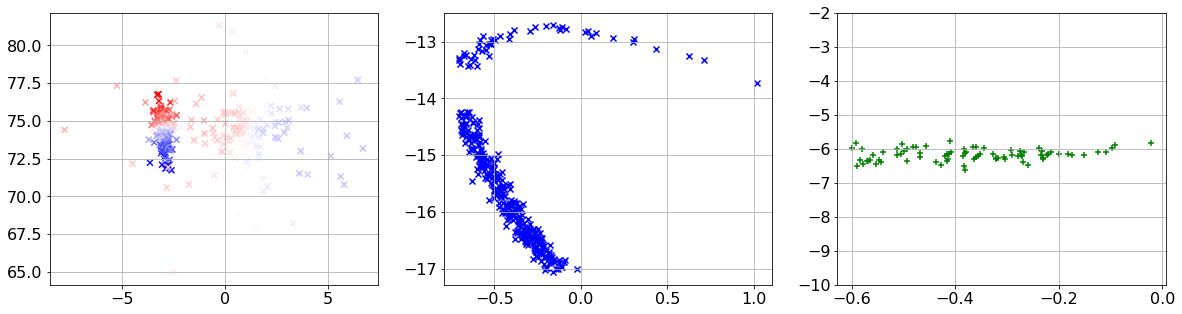

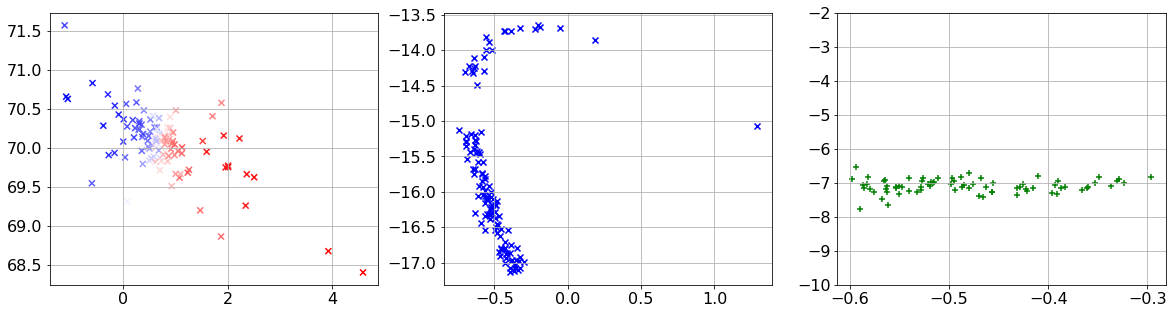

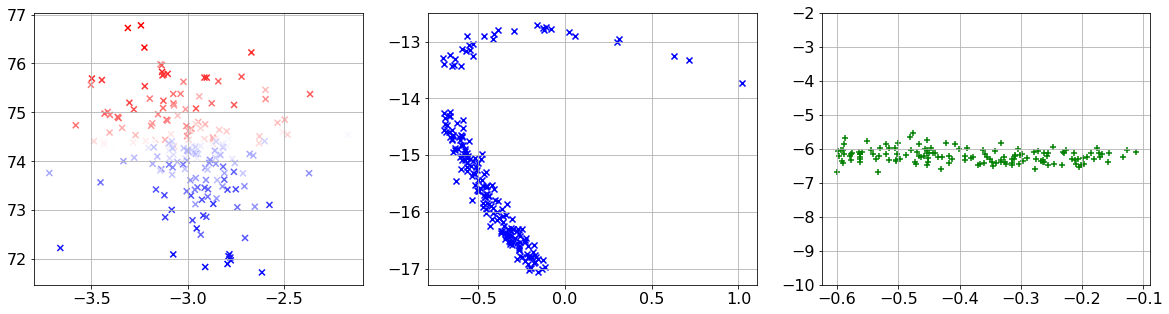

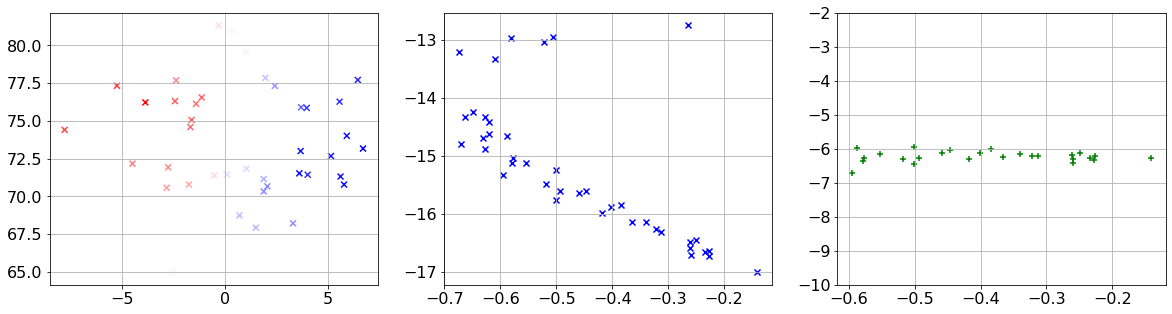

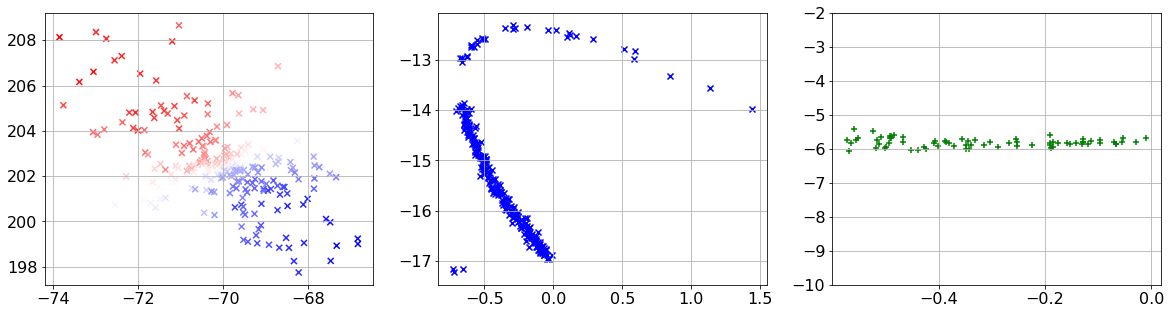

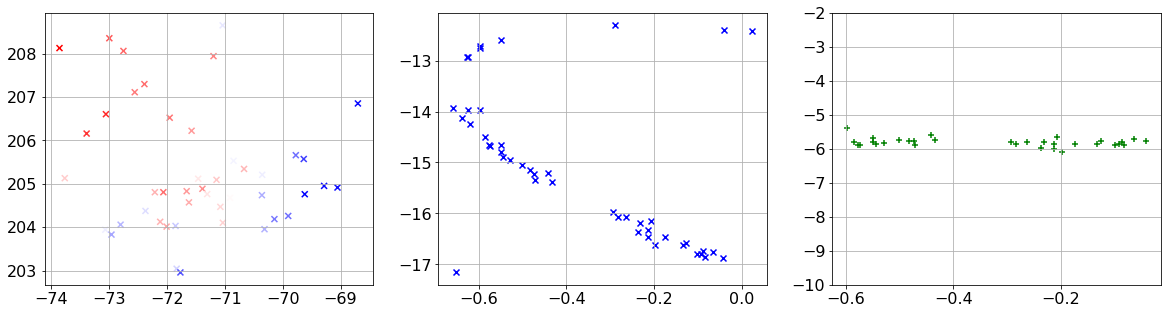

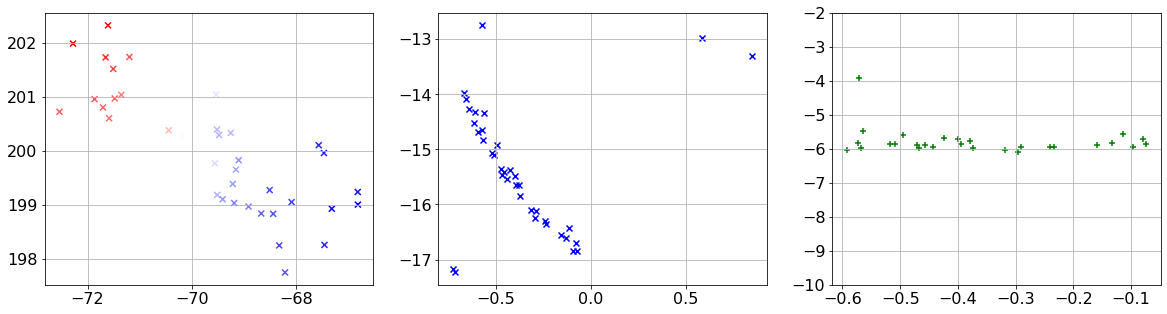

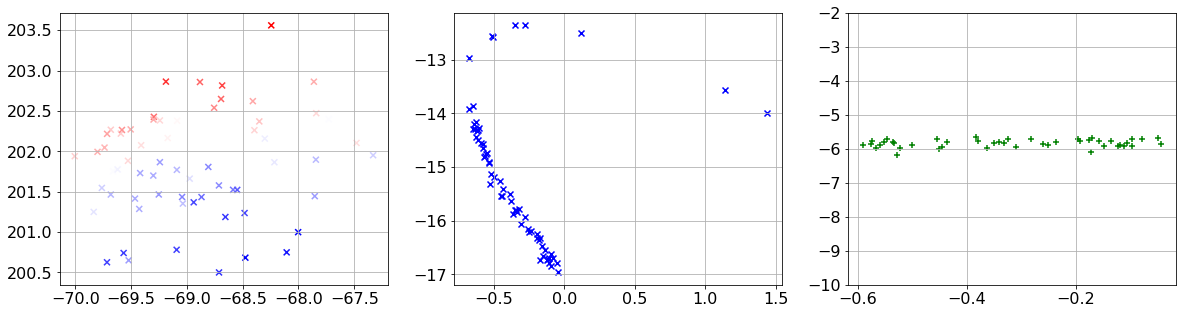

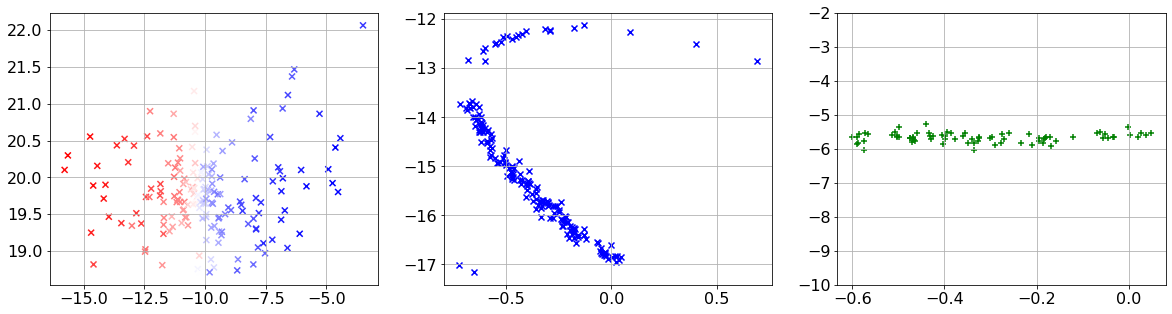

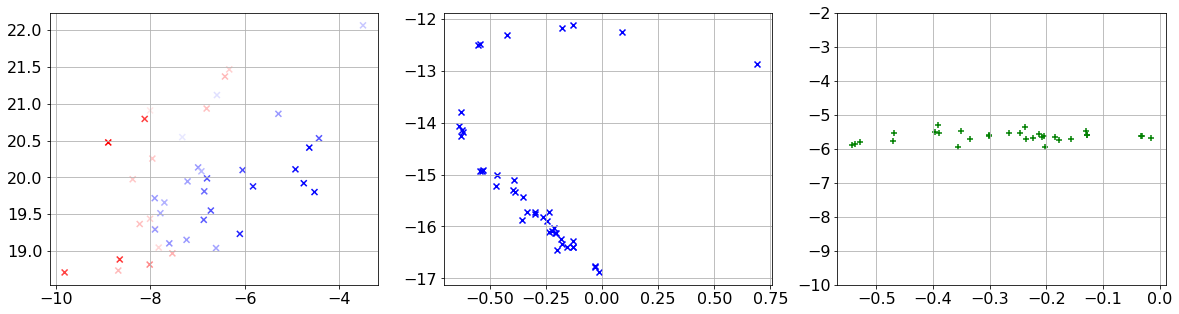

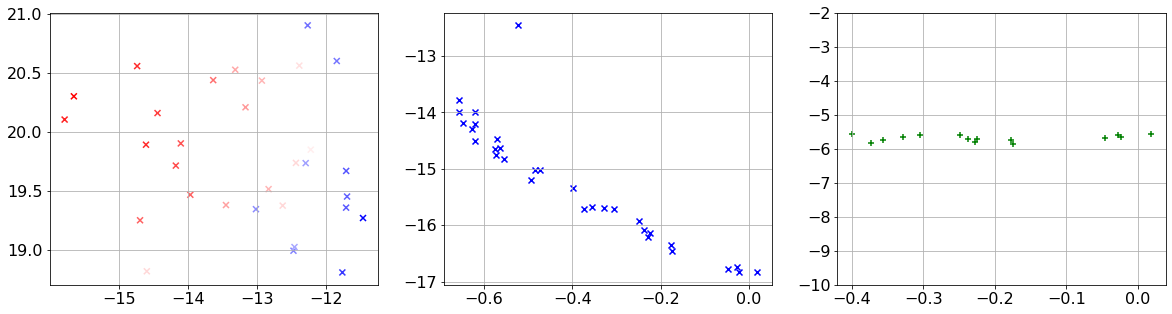

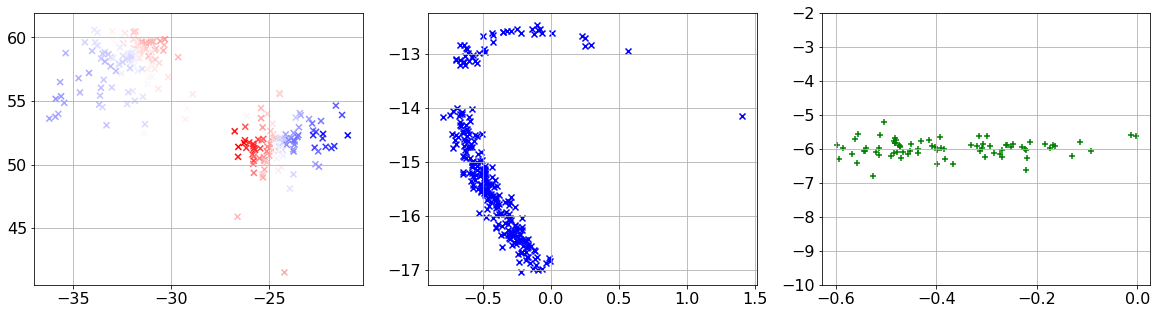

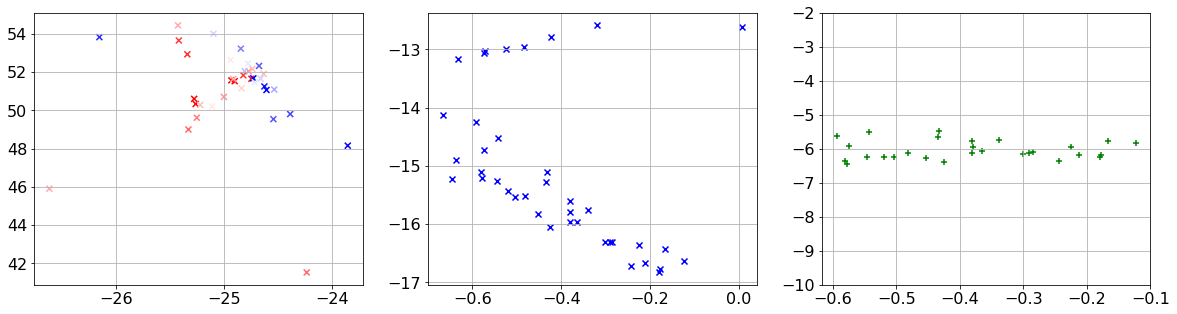

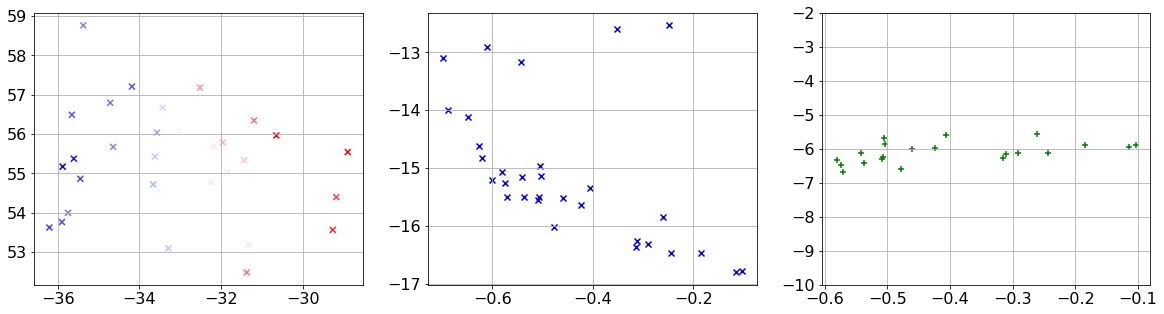

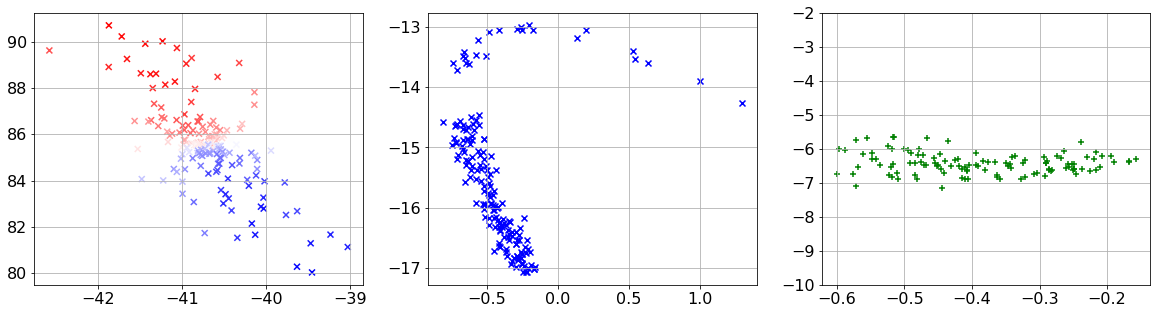

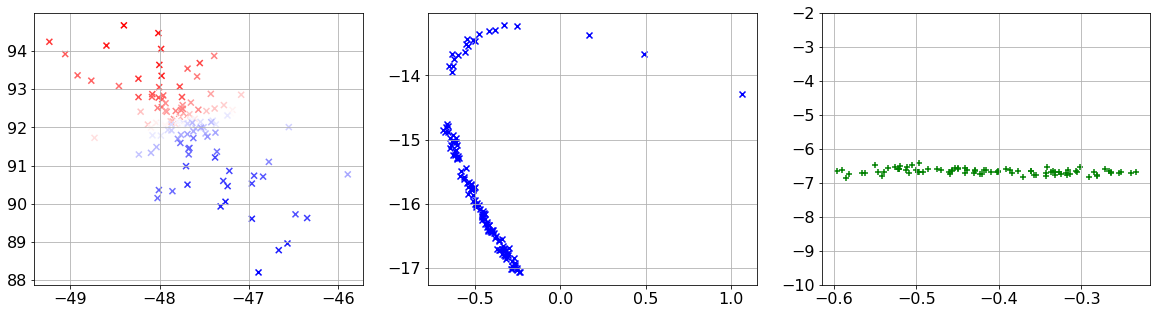

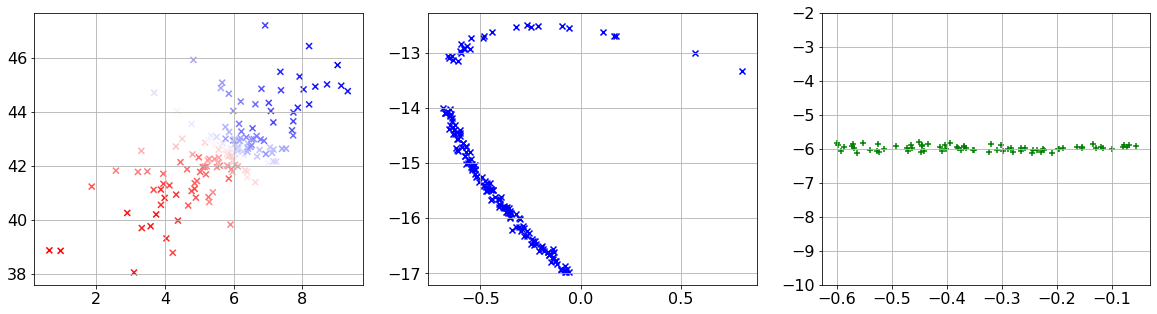

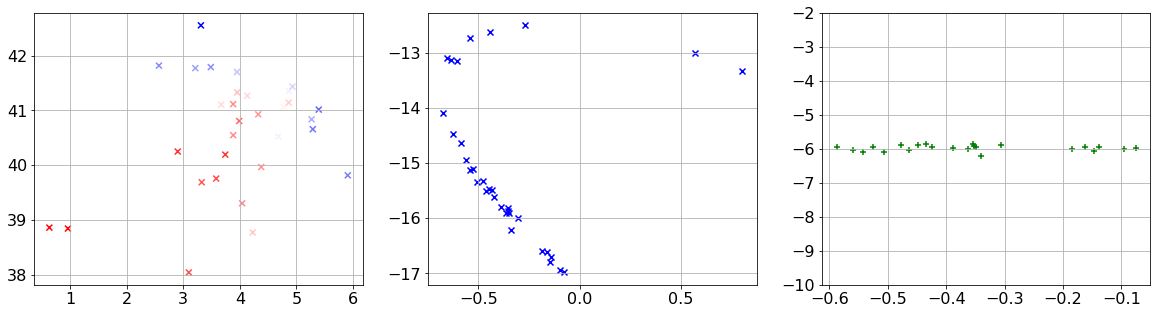

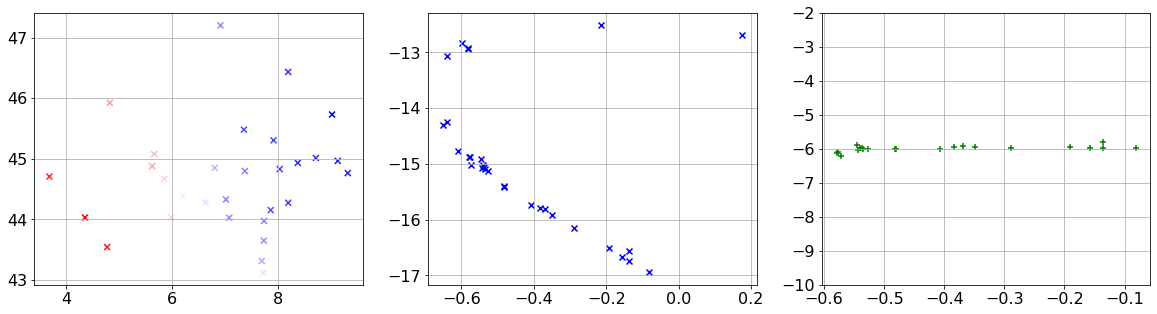

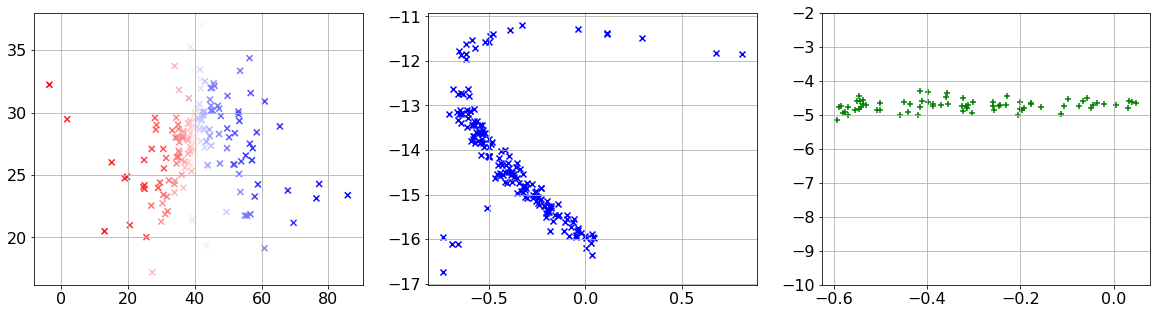

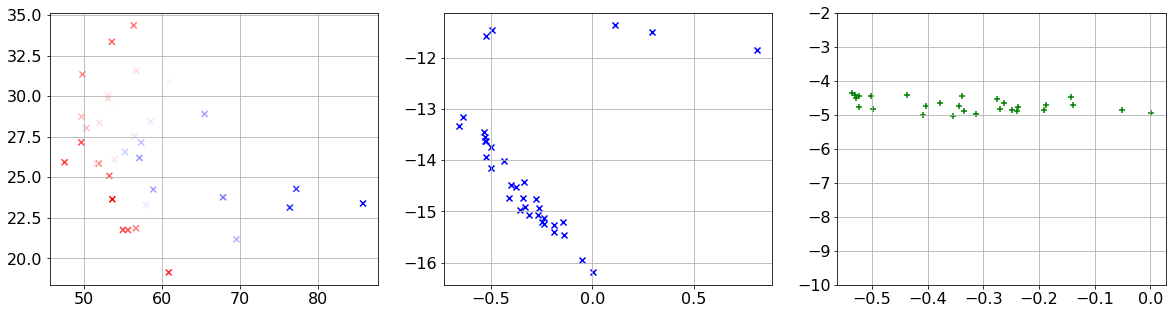

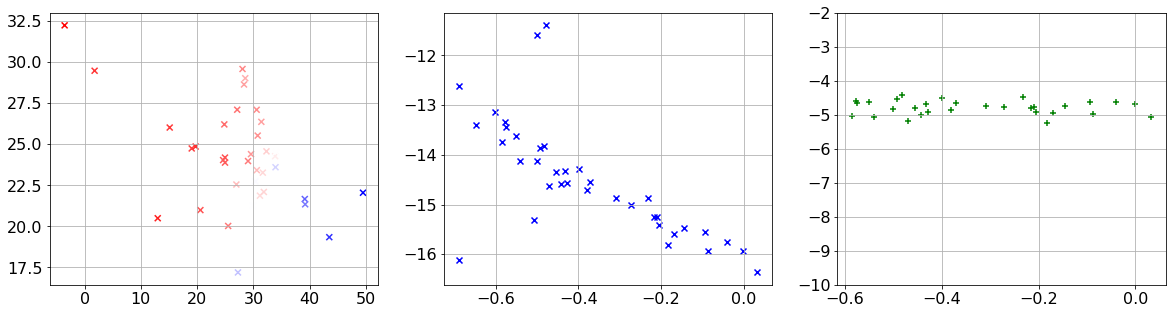

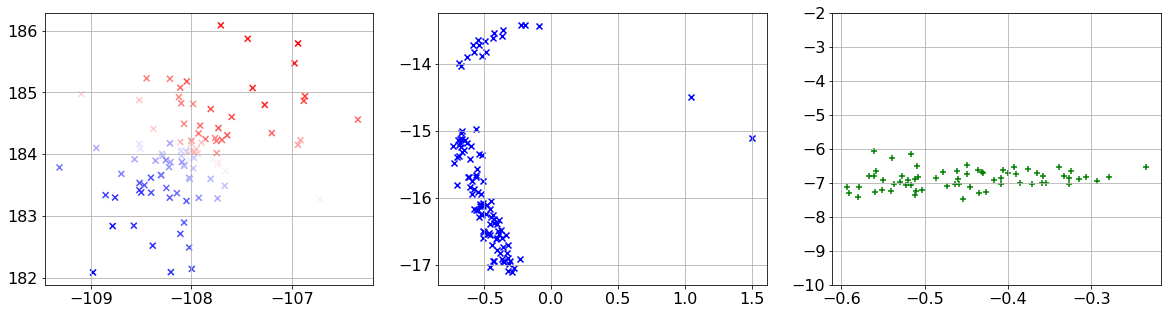

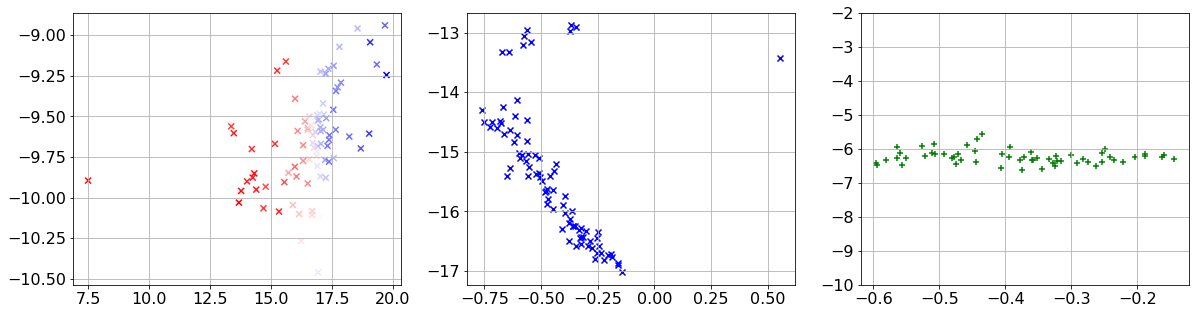

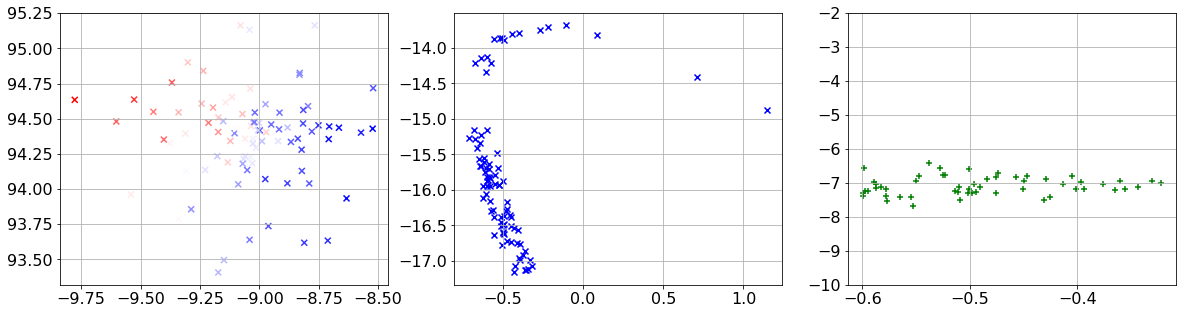

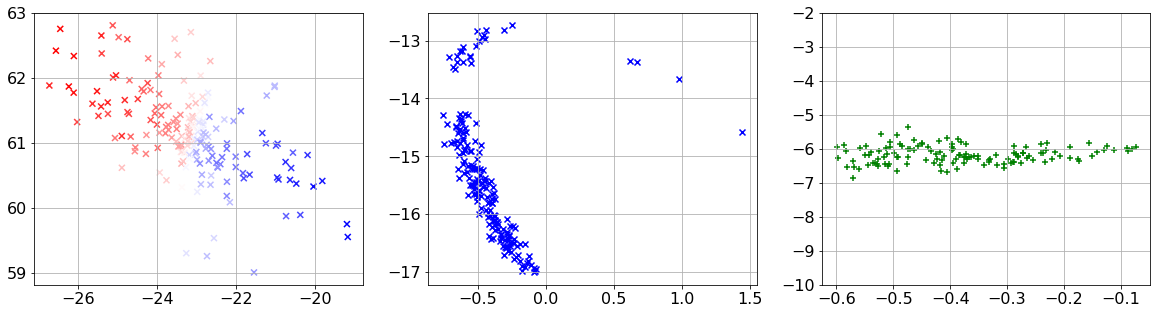

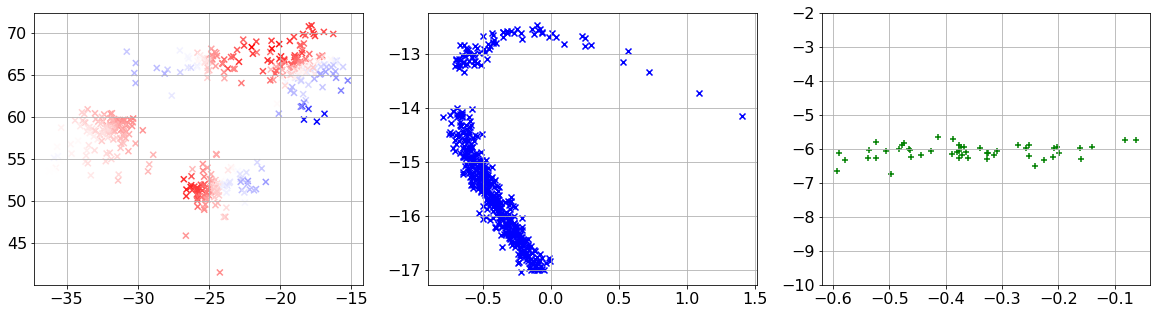

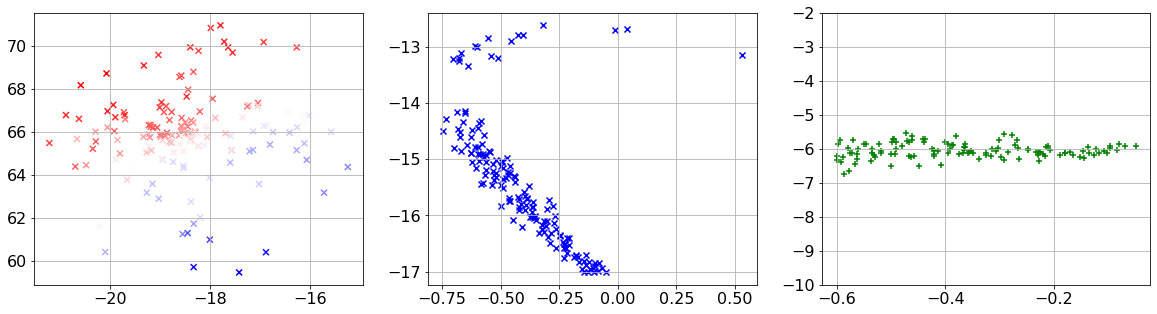

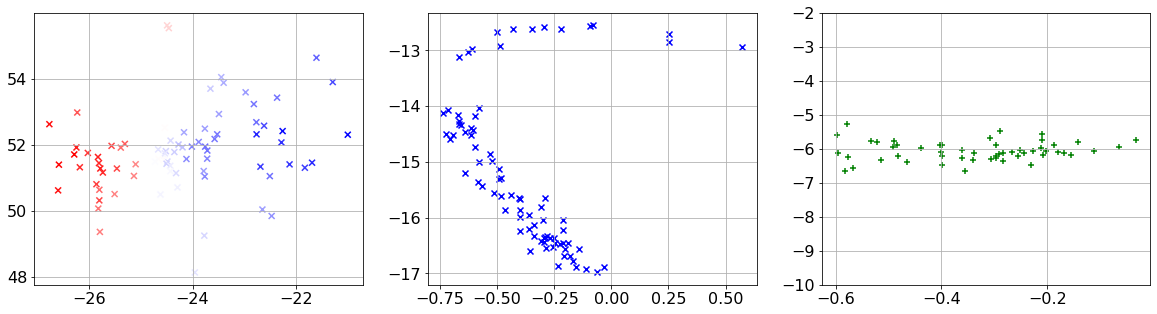

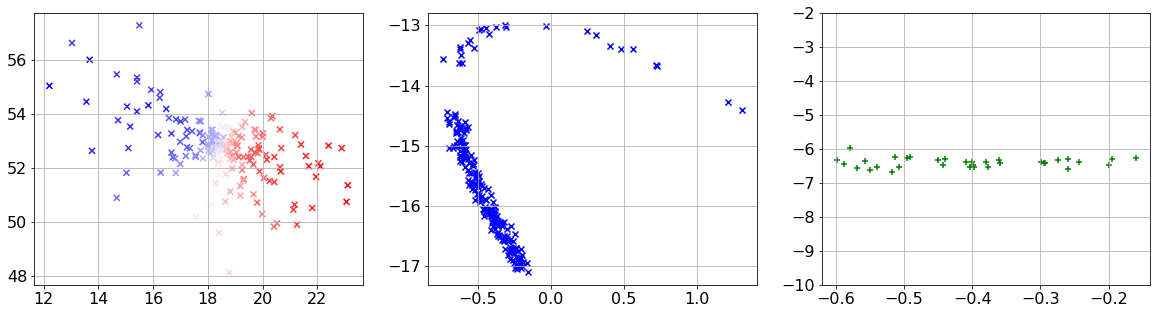

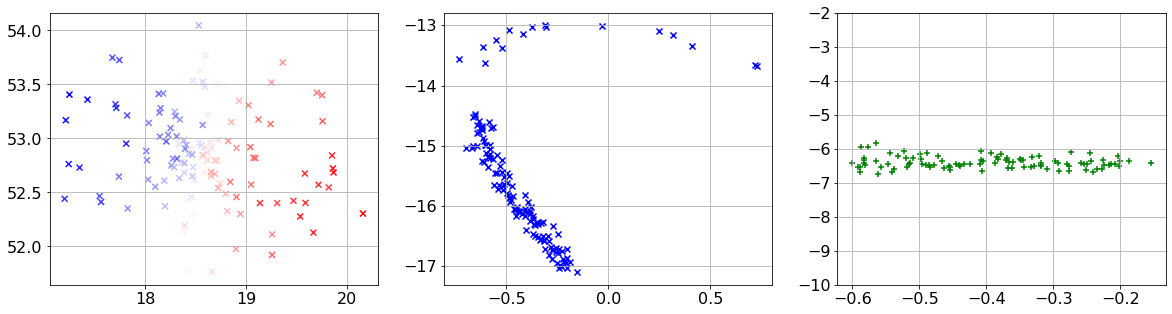

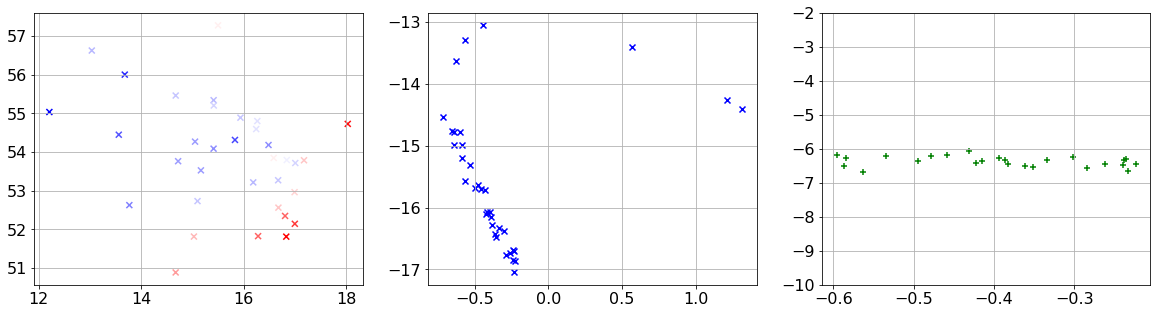

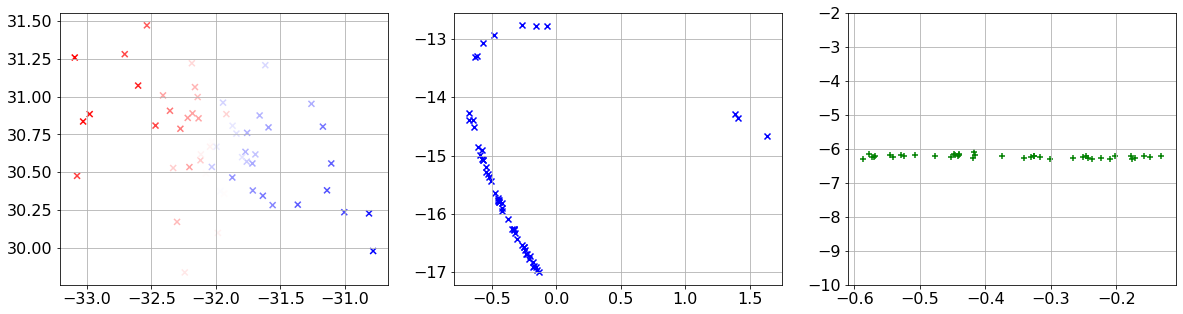

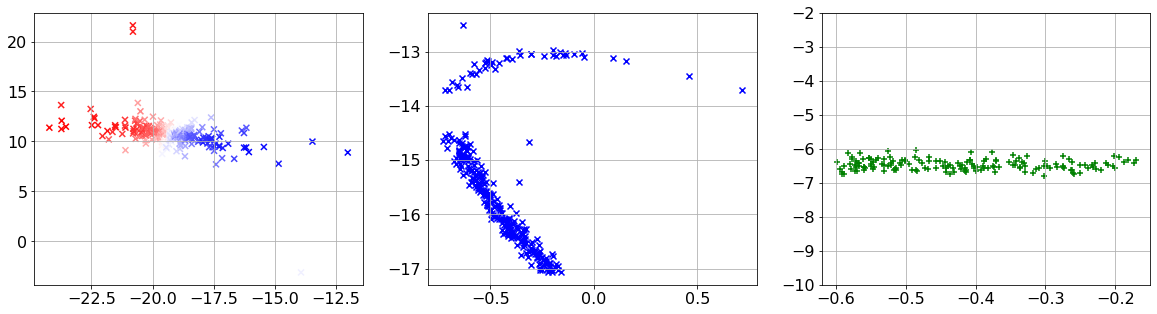

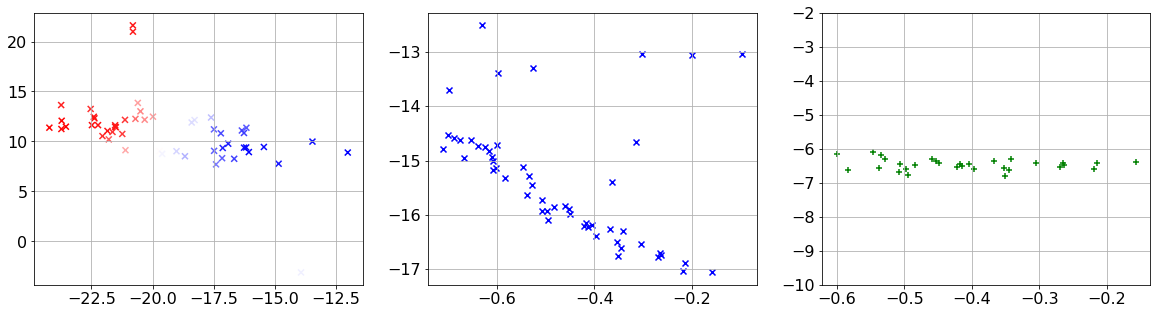

In [7]:
# Plot subClusters
subClusterPlots=[]
for i, subCluster in enumerate(subClusters):
    subClusterPlots.append(mpl.pyplot.figure())
    ### Sky map cluster plot
    ax1 = subClusterPlots[-1].add_subplot(1, 3, 1)
    plt.grid()
    mpl.pyplot.scatter(subCluster[:,1], subCluster[:,2], c= subCluster[:,5], cmap= 'bwr', marker ='x')
    ### HR diagram cluster plot
    ax2 = subClusterPlots[-1].add_subplot(1, 3, 2)
    plt.grid()
    mpl.pyplot.scatter(subCluster[:,3],subCluster[:,4], marker = 'x', color='blue')
 
    ax3 = subClusterPlots[-1].add_subplot(1, 3, 3)
    
    mpl.pyplot.scatter(subClusterMS[i][:,0],subClusterMS[i][:,1], marker = '+', color='green')
    # ax3.fill(X_plot, subCluster[2], fc="#AAAAFF")
    # ax3.set_xlim(min(farPoints_floats[:,5]),2)
    ax3.set_ylim(-10,-2)
    plt.grid()
plt.show() 

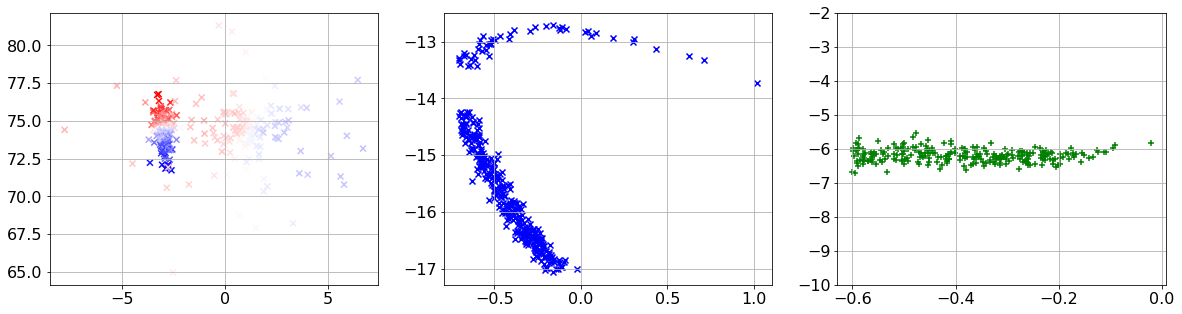

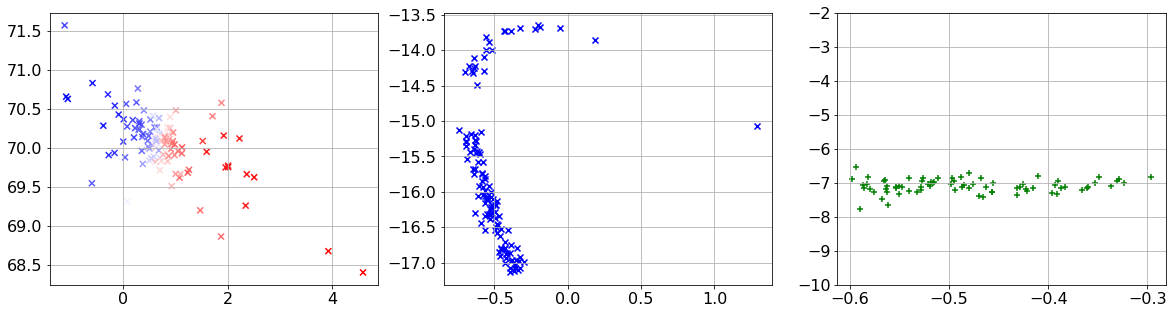

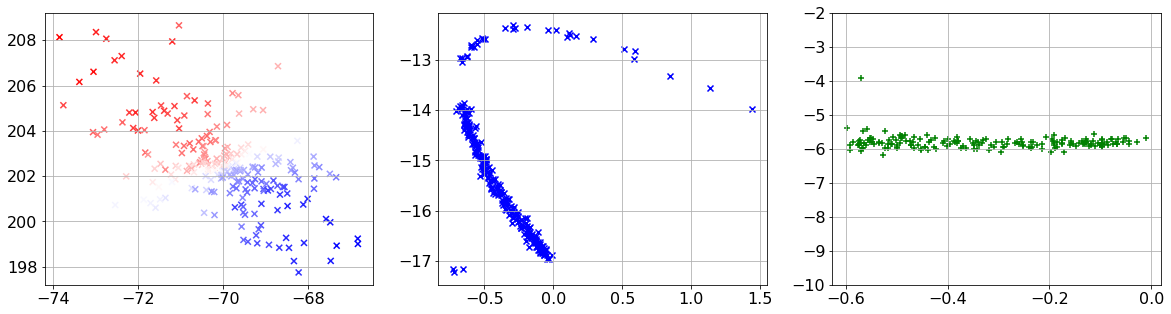

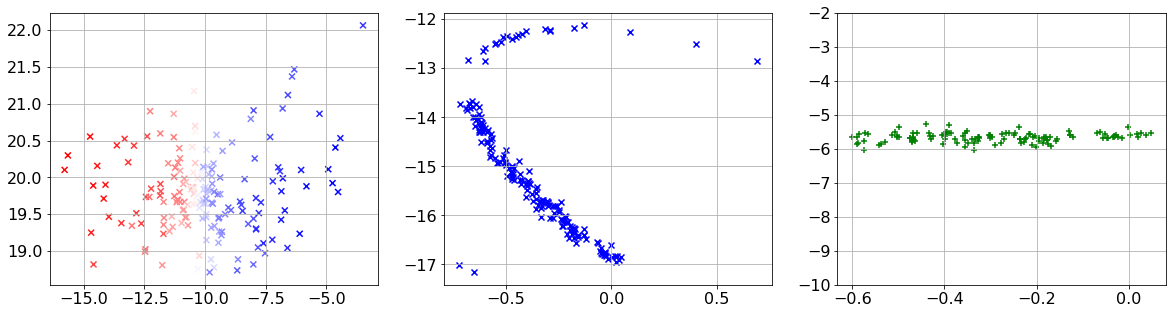

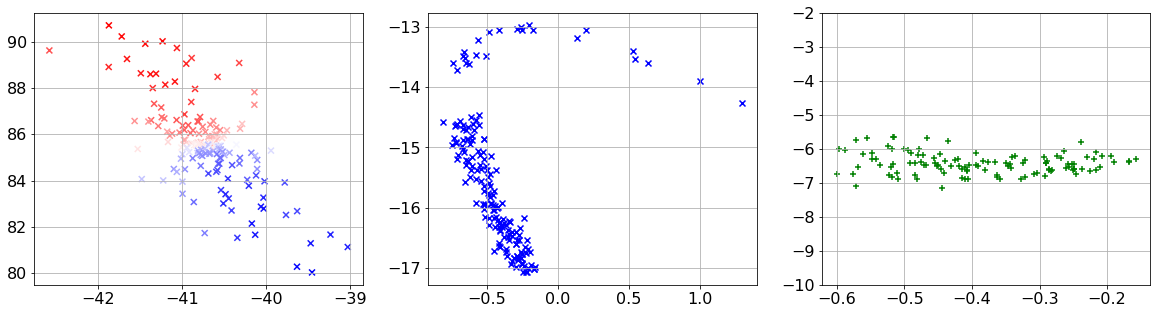

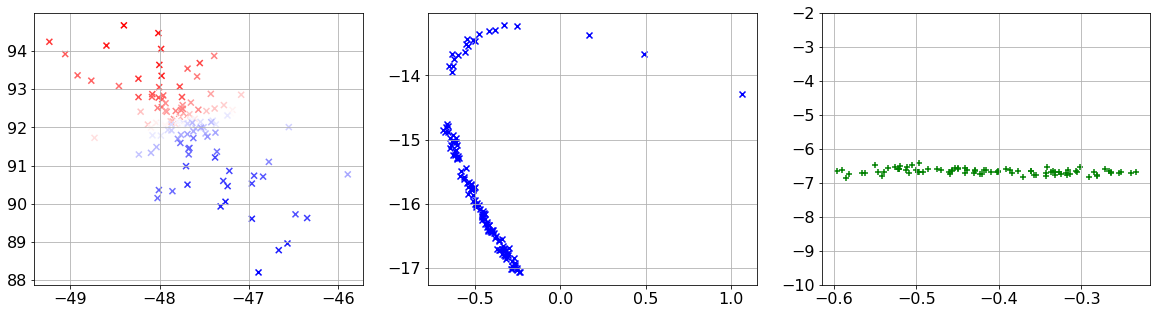

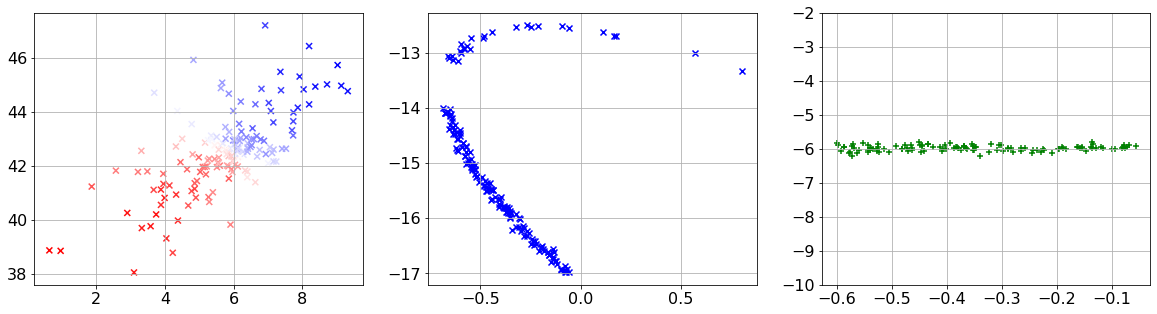

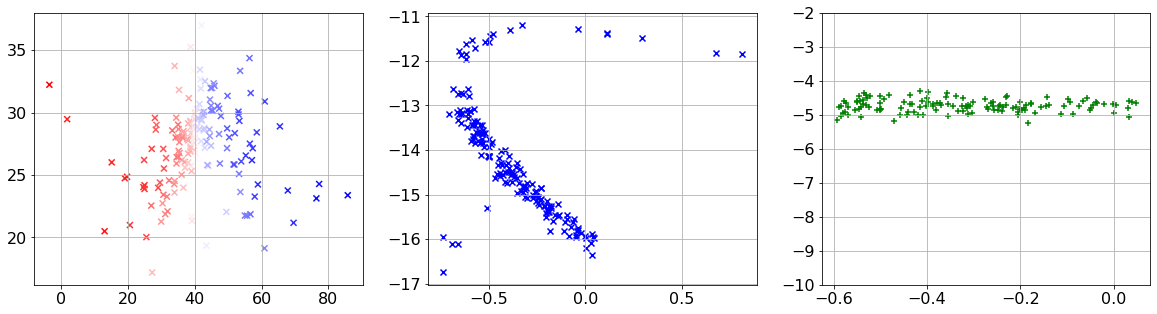

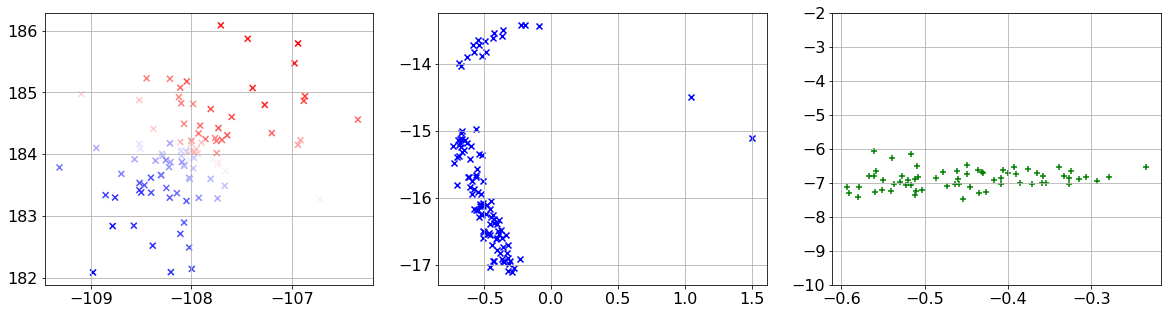

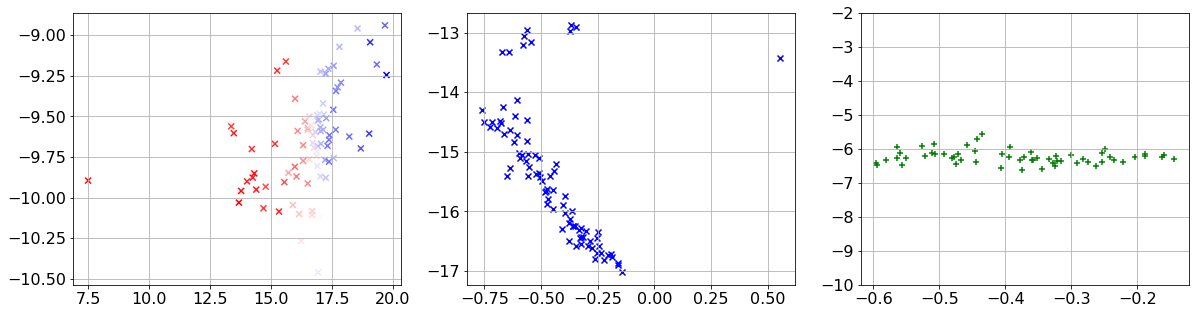

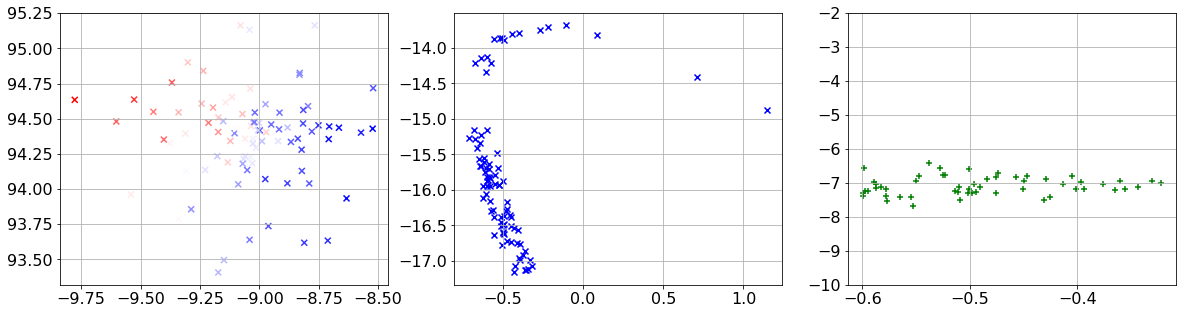

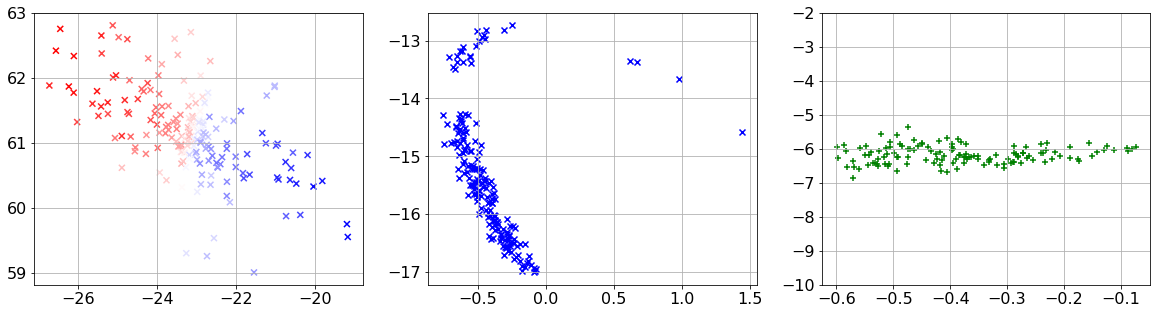

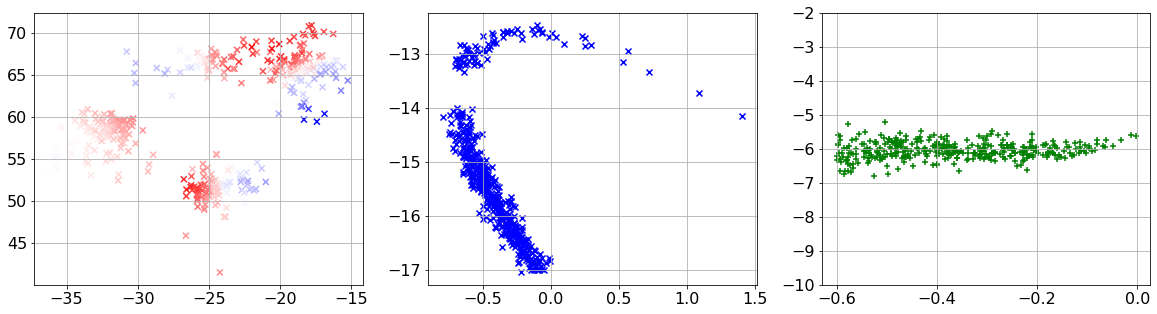

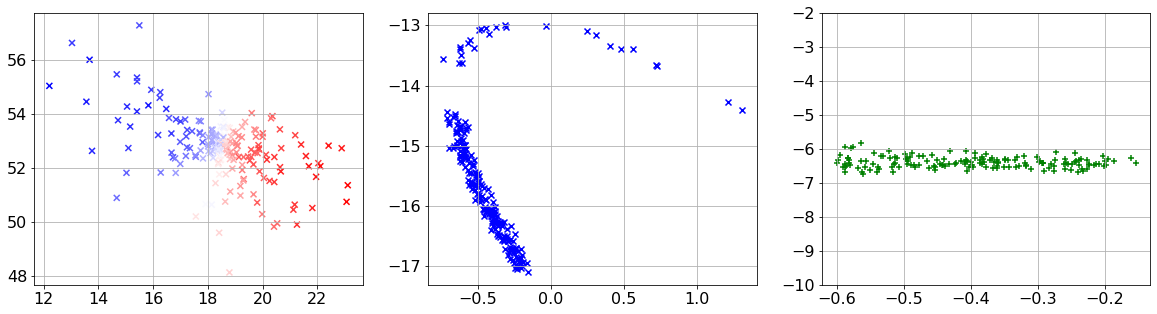

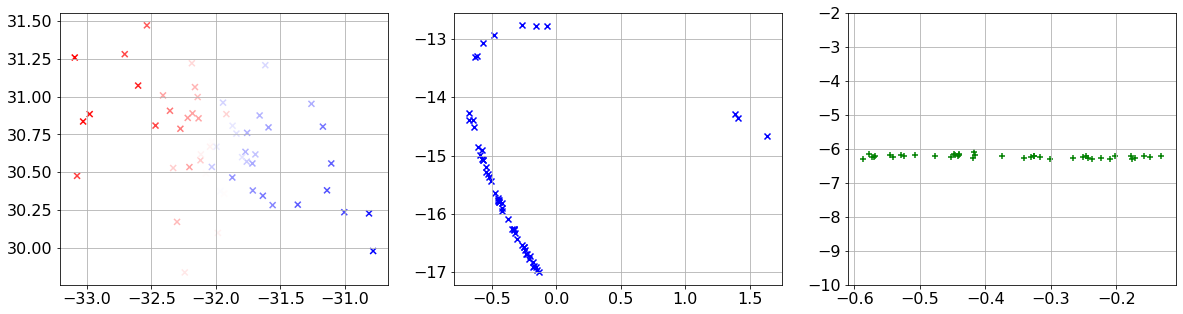

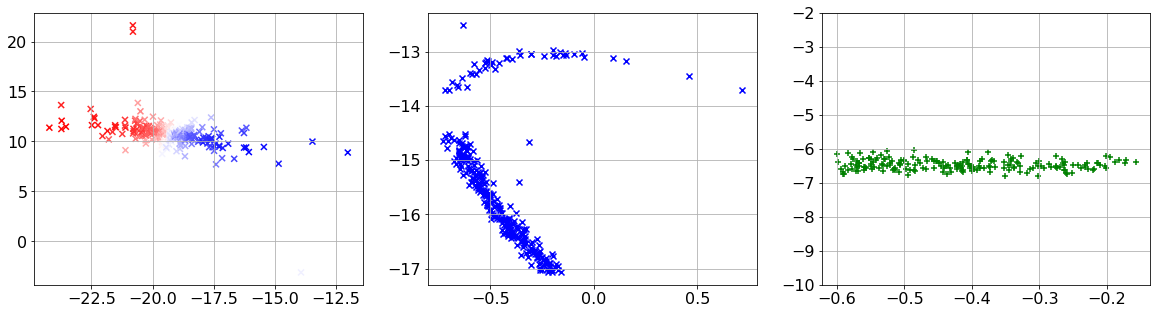

In [8]:
# Plot clusters
clusterPlots=[]
for i, cluster in enumerate(clusters):
    clusterPlots.append(mpl.pyplot.figure())
    ### Sky map cluster plot
    ax1 = clusterPlots[-1].add_subplot(1, 3, 1)
    plt.grid()
    mpl.pyplot.scatter(cluster[:,1], cluster[:,2], c= cluster[:,5], cmap= 'bwr', marker ='x')
    ### HR diagram cluster plot
    ax2 = clusterPlots[-1].add_subplot(1, 3, 2)
    plt.grid()
    mpl.pyplot.scatter(cluster[:,3],cluster[:,4], marker = 'x', color='blue')
    ax3 = clusterPlots[-1].add_subplot(1, 3, 3)
    mpl.pyplot.scatter(clusterMS[i][:,0],clusterMS[i][:,1], marker = '+', color='green')
    ax3.set_ylim(-10,-2)
    plt.grid()
plt.show() 

In [9]:
# Check Points concervation
# this section is just to check that all the points are accounted for and no coding errors have been made

totalPointsSC = 0
totalPointsC = 0
totalPointsP = 0
unassigned = unassigned

totalPointsP = 0
for protoCluster in protoClusters:
    totalPointsP = totalPointsP + len(protoCluster)
    
totalPointsSC = 0    
for subCluster in subClusters:
    totalPointsSC = totalPointsSC + len(subCluster)
    
totalPointsC = 0
for cluster in clusters:
    totalPointsC = totalPointsC + len(cluster)